# Collect EIA data on generation from nonfossil fuel sources

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

## Collect available EIA data series

#### Update to API v2
Note previous code gives error: 
    {'error': 'EIA retired APIv1 on March 13th, 2023. Please use an APIv2 call starting with /v2, or a backward compatibility call with api.eia.gov/seriesid/V1_SERIES_ID. Full documentation is available at https://www.eia.gov/opendata',
 'code': 404}

In [ ]:
apikey = ''

# 2019

In [ ]:
all_data = pd.DataFrame({'CAL_COL':np.zeros((8760,))})
# for fuel in ['OIL', 'WND', 'SUN']:
for fuel in ['COL', 'WAT', 'NG', 'NUC', 'OTH', 'OIL', 'WND', 'SUN']:
    for region in ['CAL', 'SW', 'NW']:
        df_combined_here = None
        for month, length in {'01':'31', '02':'28', '03':'31', '04':'30', '05':'31', '06':'30', '07':'31', '08':'31', '09':'30', '10':'31', '11':'30', '12':'31'}.items():
            next_month = {'01':'02', '02':'03', '03':'04', '04':'05', '05':'06', '06':'07', '07':'08', '08':'09', '09':'10', '10':'11', '11':'12', '12':'01'}
            if month in ['01', '02']: # UTC-8h
                # get values in UTC
                start_date = '2019-'+month+'-01T08'# 8 hours after the 1st at 00h00
                end_date = '2019-'+next_month[month]+'-'+'01'+'T07' # 8 hours after the 31st at 23h00
            elif month in ['03']: # UTC-8h
                # get values in UTC
                start_date = '2019-'+month+'-01T08'# 8 hours after the 1st at 00h00
                end_date = '2019-'+next_month[month]+'-'+'01'+'T06' # 7 hours after the 31st at 23h00
            elif month in ['04', '05', '06', '07', '08', '09', '10']: # UTC-8h
                # get values in UTC
                start_date = '2019-'+month+'-01T07'# 7 hours after the 1st at 00h00
                end_date = '2019-'+next_month[month]+'-'+'01'+'T06' # 7 hours after the 31st at 23h00
            elif month in ['11']: # UTC-8h
                # get values in UTC
                start_date = '2019-'+month+'-01T07'# 7 hours after the 1st at 00h00
                end_date = '2019-'+next_month[month]+'-'+'01'+'T07' # 8 hours after the 31st at 23h00
            elif month in ['12']: # UTC-8h
                # get values in UTC
                start_date = '2019-'+month+'-01T08'# 8 hours after the 1st at 00h00
                end_date = '2020-'+next_month[month]+'-'+'01'+'T07' # 8 hours after the 31st at 23h00

            url = 'http://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?api_key='+apikey+'&frequency=hourly&data[0]=value&facets[respondent][]='+region+'&facets[fueltype][]='+fuel+'&start='+start_date+'&end='+end_date+'&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
            r = requests.get(url)
            j = r.json()
            data_here = pd.DataFrame(j['response']['data'], columns=['period', 'respondent', 'fueltype', 'type-name', 'value', 'value-units'])
            data_here['dt_UTC'] = pd.to_datetime(data_here['period'], utc=True)
            data_here = data_here.sort_values(by='dt_UTC').reset_index(drop=True)
            data_here['dt_local'] = data_here['dt_UTC'].dt.tz_convert("US/Pacific")

            if df_combined_here is None:
                df_combined_here = data_here.copy(deep=True)
            else:
                df_combined_here = pd.concat((df_combined_here, data_here), axis=0, ignore_index=True)

        # Deal with daylight savings missing hour to make 8760:
        df_combined_here['no_dt_index'] = np.copy(df_combined_here.index.values)
        
        march_index = df_combined_here[df_combined_here['dt_local']=='2019-03-10 01:00:00-08:00'].index.values[0]       
        idadd = len(df_combined_here)
        for key in ['respondent', 'fueltype', 'type-name', 'value', 'value-units']:
            df_combined_here.loc[idadd, key] = df_combined_here.loc[march_index, key]
        df_combined_here.loc[idadd, 'dt_local'] = df_combined_here.loc[march_index, 'dt_local'] + datetime.timedelta(hours=1)
        df_combined_here.loc[idadd, 'no_dt_index'] = 0.5 + df_combined_here.loc[march_index, 'no_dt_index']
        print('Added march: ', 0.5 + df_combined_here.loc[march_index, 'no_dt_index'])
        print(df_combined_here.loc[idadd])

        
        
        
        if region == 'CAL':
            if fuel in ['NUC', 'OIL']:
                # somehow missed 2019-08-25 14:00:00
                aug_index = df_combined_here[df_combined_here['dt_local']=='2019-08-25 13:00:00-07:00'].index.values[0]       
                idadd = len(df_combined_here)
                for key in ['respondent', 'fueltype', 'type-name', 'value', 'value-units']:
                    df_combined_here.loc[idadd, key] = df_combined_here.loc[aug_index, key]
                df_combined_here.loc[idadd, 'no_dt_index'] = 0.5 + df_combined_here.loc[aug_index, 'no_dt_index']
                df_combined_here.loc[idadd, 'dt_local'] = df_combined_here.loc[aug_index, 'dt_local'] + datetime.timedelta(hours=1)
                print('Added missing August.')
                print(df_combined_here.loc[idadd])
            if fuel == 'OIL':
                # somehow also missed 2019-12-19 16:00:00, 17, and 18
                dec_index = df_combined_here[df_combined_here['dt_local']=='2019-12-19 15:00:00-08:00'].index.values[0]       
                idadd = len(df_combined_here)
                for key in ['respondent', 'fueltype', 'type-name', 'value', 'value-units']:
                    df_combined_here.loc[idadd, key] = df_combined_here.loc[dec_index, key]
                df_combined_here.loc[idadd, 'no_dt_index'] = 0.1 + df_combined_here.loc[dec_index, 'no_dt_index']
                df_combined_here.loc[idadd, 'dt_local'] = df_combined_here.loc[dec_index, 'dt_local'] + datetime.timedelta(hours=1)
                idadd = len(df_combined_here)
                for key in ['respondent', 'fueltype', 'type-name', 'value', 'value-units']:
                    df_combined_here.loc[idadd, key] = df_combined_here.loc[dec_index, key]
                df_combined_here.loc[idadd, 'no_dt_index'] = 0.2 + df_combined_here.loc[dec_index, 'no_dt_index']
                df_combined_here.loc[idadd, 'dt_local'] = df_combined_here.loc[dec_index, 'dt_local'] + datetime.timedelta(hours=2)
                idadd = len(df_combined_here)
                for key in ['respondent', 'fueltype', 'type-name', 'value', 'value-units']:
                    df_combined_here.loc[idadd, key] = df_combined_here.loc[dec_index, key]
                df_combined_here.loc[idadd, 'no_dt_index'] = 0.3 + df_combined_here.loc[dec_index, 'no_dt_index']
                df_combined_here.loc[idadd, 'dt_local'] = df_combined_here.loc[dec_index, 'dt_local'] + datetime.timedelta(hours=3)
                
                
        nov_index = df_combined_here[df_combined_here['dt_local']=='2019-11-03 01:00:00-08:00'].index.values[0]
        df_combined_here = df_combined_here.drop(index=nov_index)
                
        df_combined_here = df_combined_here.sort_values(by='no_dt_index').reset_index(drop=True)  
        
                
        all_data[region+'_'+fuel] = df_combined_here['value'].values

all_data['dt'] = df_combined_here['dt_local']

for fuel in ['COL', 'WAT', 'NG', 'NUC', 'OTH', 'OIL', 'WND', 'SUN']:

    all_data['SW_'+fuel] = all_data['SW_'+fuel].astype(float)
    all_data['NW_'+fuel] = all_data['NW_'+fuel].astype(float)
    all_data['CAL_'+fuel] = all_data['CAL_'+fuel].astype(float)
    
    all_data['WECC_'+fuel] = all_data['SW_'+fuel] + all_data['NW_'+fuel] + all_data['CAL_'+fuel]
for loc in ['WECC', 'SW', 'NW', 'CAL']:
    all_data[loc+'_OTH_GEO'] = 0.65*all_data[loc+'_OTH'] # see '3_Generator_Additions for this fraction'
    all_data[loc+'_OTH_COMB'] = 0.35*all_data[loc+'_OTH']
    
all_data['WECC_combustion'] = all_data.loc[:, ['WECC_COL', 'WECC_NG', 'WECC_OIL', 'WECC_OTH_COMB']].sum(axis=1)
all_data['WECC_notcombustion'] = all_data.loc[:, ['WECC_WAT', 'WECC_NUC', 'WECC_WND', 'WECC_SUN', 'WECC_OTH_GEO']].sum(axis=1)


all_data.to_csv('../Data/region_eia_generation_data_2019.csv')

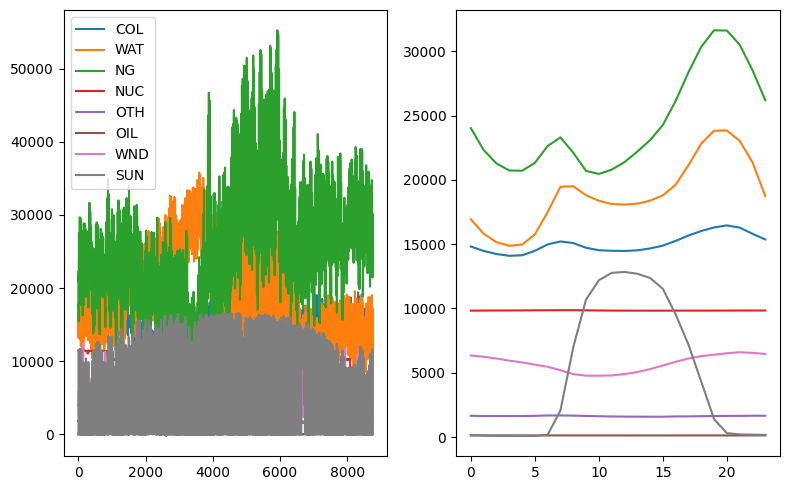

In [137]:
fig, axes = plt.subplots(1, 2, figsize=(8,5))
for fuel in ['COL', 'WAT', 'NG', 'NUC', 'OTH', 'OIL', 'WND', 'SUN']:
    axes[0].plot(all_data['WECC_'+fuel], label=fuel)
    axes[1].plot(all_data['WECC_'+fuel].values.reshape(-1, 24).mean(axis=0), label=fuel)
axes[0].legend()
plt.tight_layout()
plt.show()

# 2022

In [ ]:
all_data = pd.DataFrame({'CAL_COL':np.zeros((8760,))})
for fuel in ['COL', 'WAT', 'NG', 'NUC', 'OTH', 'OIL', 'WND', 'SUN']:
    for region in ['CAL', 'SW', 'NW']:
        df_combined_here = None
        for month, length in {'01':'31', '02':'28', '03':'31', '04':'30', '05':'31', '06':'30', '07':'31', '08':'31', '09':'30', '10':'31', '11':'30', '12':'31'}.items():
            next_month = {'01':'02', '02':'03', '03':'04', '04':'05', '05':'06', '06':'07', '07':'08', '08':'09', '09':'10', '10':'11', '11':'12', '12':'01'}
            if month in ['01', '02']: # UTC-8h
                # get values in UTC
                start_date = '2022-'+month+'-01T08'# 8 hours after the 1st at 00h00
                end_date = '2022-'+next_month[month]+'-'+'01'+'T07' # 8 hours after the 31st at 23h00
            elif month in ['03']: # UTC-8h
                # get values in UTC
                start_date = '2022-'+month+'-01T08'# 8 hours after the 1st at 00h00
                end_date = '2022-'+next_month[month]+'-'+'01'+'T06' # 7 hours after the 31st at 23h00
            elif month in ['04', '05', '06', '07', '08', '09', '10']: # UTC-8h
                # get values in UTC
                start_date = '2022-'+month+'-01T07'# 7 hours after the 1st at 00h00
                end_date = '2022-'+next_month[month]+'-'+'01'+'T06' # 7 hours after the 31st at 23h00
            elif month in ['11']: # UTC-8h
                # get values in UTC
                start_date = '2022-'+month+'-01T07'# 7 hours after the 1st at 00h00
                end_date = '2022-'+next_month[month]+'-'+'01'+'T07' # 8 hours after the 31st at 23h00
            elif month in ['12']: # UTC-8h
                # get values in UTC
                start_date = '2022-'+month+'-01T08'# 8 hours after the 1st at 00h00
                end_date = '2023-'+next_month[month]+'-'+'01'+'T07' # 8 hours after the 31st at 23h00

            url = 'http://api.eia.gov/v2/electricity/rto/fuel-type-data/data/?api_key='+apikey+'&frequency=hourly&data[0]=value&facets[respondent][]='+region+'&facets[fueltype][]='+fuel+'&start='+start_date+'&end='+end_date+'&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000'
            r = requests.get(url)
            j = r.json()
            data_here = pd.DataFrame(j['response']['data'], columns=['period', 'respondent', 'fueltype', 'type-name', 'value', 'value-units'])
            data_here['dt_UTC'] = pd.to_datetime(data_here['period'], utc=True)
            data_here = data_here.sort_values(by='dt_UTC').reset_index(drop=True)
            data_here['dt_local'] = data_here['dt_UTC'].dt.tz_convert("US/Pacific")

            if df_combined_here is None:
                df_combined_here = data_here.copy(deep=True)
            else:
                df_combined_here = pd.concat((df_combined_here, data_here), axis=0, ignore_index=True)

        # Deal with daylight savings missing hour to make 8760:
        df_combined_here['no_dt_index'] = np.copy(df_combined_here.index.values)
        
        march_index = df_combined_here[df_combined_here['dt_local']=='2022-03-13 01:00:00-08:00'].index.values[0]       
        idadd = len(df_combined_here)
        for key in ['respondent', 'fueltype', 'type-name', 'value', 'value-units']:
            df_combined_here.loc[idadd, key] = df_combined_here.loc[march_index, key]
        df_combined_here.loc[idadd, 'no_dt_index'] = 0.5 + df_combined_here.loc[march_index, 'no_dt_index']

        nov_index = df_combined_here[df_combined_here['dt_local']=='2022-11-06 01:00:00-08:00'].index.values[0]
        df_combined_here = df_combined_here.drop(index=nov_index)
        
        df_combined_here = df_combined_here.sort_values(by='no_dt_index').reset_index(drop=True)                
                
        all_data[region+'_'+fuel] = df_combined_here['value'].values
all_data['dt'] = df_combined_here['dt_local']

for fuel in ['COL', 'WAT', 'NG', 'NUC', 'OTH', 'OIL', 'WND', 'SUN']:
    
    all_data['SW_'+fuel] = all_data['SW_'+fuel].astype(float)
    all_data['NW_'+fuel] = all_data['NW_'+fuel].astype(float)
    all_data['CAL_'+fuel] = all_data['CAL_'+fuel].astype(float)
    
    all_data['WECC_'+fuel] = all_data['SW_'+fuel] + all_data['NW_'+fuel] + all_data['CAL_'+fuel]

for loc in ['WECC', 'SW', 'NW', 'CAL']:
    all_data[loc+'_OTH_GEO'] = 0.65*all_data[loc+'_OTH'] # see '3_Generator_Additions for this fraction'
    all_data[loc+'_OTH_COMB'] = 0.35*all_data[loc+'_OTH']
    
all_data['WECC_combustion'] = all_data.loc[:, ['WECC_COL', 'WECC_NG', 'WECC_OIL', 'WECC_OTH_COMB']].sum(axis=1)
all_data['WECC_notcombustion'] = all_data.loc[:, ['WECC_WAT', 'WECC_NUC', 'WECC_WND', 'WECC_SUN', 'WECC_OTH_GEO']].sum(axis=1)


all_data.to_csv('../Data/region_eia_generation_data_2022.csv')

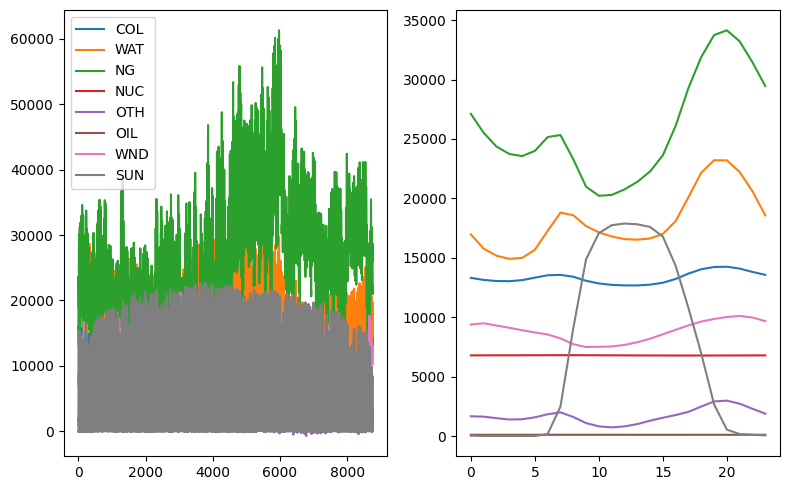

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(8,5))
for fuel in ['COL', 'WAT', 'NG', 'NUC', 'OTH', 'OIL', 'WND', 'SUN']:
    axes[0].plot(all_data['WECC_'+fuel], label=fuel)
    axes[1].plot(all_data['WECC_'+fuel].values.reshape(-1, 24).mean(axis=0), label=fuel)
axes[0].legend()
plt.tight_layout()
plt.show()

### Geothermal fraction of OTH
EIA data gives only 'OTH' category, without specifying split between geothermal and biomass. We use the capacity factors in the wecc data to estimate the split.

In [9]:
geo_fraction_of_other = {}

In [11]:
year = '2019'
year_string = '19'

egrid_data_xlsx = '../Data/GridInputData/eGRID'+year+'_data.xlsx'
egrid_gen = pd.read_excel(egrid_data_xlsx, 'GEN'+year_string, skiprows=[0])
egrid_gen['orispl_unit'] = egrid_gen['ORISPL'].map(str) + '_' + egrid_gen['GENID'].map(str)
egrid_plnt = pd.read_excel(egrid_data_xlsx, 'PLNT'+year_string, skiprows=[0])
wecc_orispl = egrid_plnt[egrid_plnt['NERC']=='WECC']['ORISPL'].values

# geothermal and biomass namepcap in wecc plants
geo_val = egrid_gen.loc[(egrid_gen['FUELG1'].isin(['GEO']))&(egrid_gen['ORISPL'].isin(wecc_orispl))]['NAMEPCAP'].sum()
biomass_val = egrid_gen.loc[(egrid_gen['FUELG1'].isin(['AB', 'LFG', 'MSW', 'OBG' ,'OBL', 'OBS', 'OG', 'OTH', 'WDL', 'WDS']))&(egrid_gen['ORISPL'].isin(wecc_orispl))]['NAMEPCAP'].sum()
print('Geo:', geo_val)
print('Biomass etc:', biomass_val)
print('Geo fraction: ', geo_val / (geo_val + biomass_val))

geo_fraction_of_other[year] = geo_val / (geo_val + biomass_val)

Geo: 4768.1
Biomass etc: 2728.5
Geo fraction:  0.6360350025344823


In [13]:
year = '2022'
year_string = '22'

egrid_data_xlsx = '../Data/GridInputData/eGRID'+year+'_data.xlsx'
egrid_gen = pd.read_excel(egrid_data_xlsx, 'GEN'+year_string, skiprows=[0])
egrid_gen['orispl_unit'] = egrid_gen['ORISPL'].map(str) + '_' + egrid_gen['GENID'].map(str)
egrid_plnt = pd.read_excel(egrid_data_xlsx, 'PLNT'+year_string, skiprows=[0])
wecc_orispl = egrid_plnt[egrid_plnt['NERC']=='WECC']['ORISPL'].values

# geothermal and biomass namepcap in wecc plants
geo_val = egrid_gen.loc[(egrid_gen['FUELG1'].isin(['GEO']))&(egrid_gen['ORISPL'].isin(wecc_orispl))]['NAMEPCAP'].sum()
biomass_val = egrid_gen.loc[(egrid_gen['FUELG1'].isin(['AB', 'LFG', 'MSW', 'OBG' ,'OBL', 'OBS', 'OG', 'OTH', 'WDL', 'WDS']))&(egrid_gen['ORISPL'].isin(wecc_orispl))]['NAMEPCAP'].sum()
print('Geo:', geo_val)
print('Biomass etc:', biomass_val)
print('Geo fraction: ', geo_val / (geo_val + biomass_val))

geo_fraction_of_other[year] = geo_val / (geo_val + biomass_val)

Geo: 3972.7000000000003
Biomass etc: 2145.9
Geo fraction:  0.6492825156081456


Conclusion: approximate as 65%.